Version 2025.01.02 - A. Lundervold

Lab 1: using the `elemd219-2025`conda environment 


[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2025/blob/main/Lab1-NetworkSci-PSN/notebooks/03-patient-similarity-networks-ibs-brain.ipynb)

# Patient similarity networks - ibs-brain

(https://github.com/arvidl/ibs-brain)

#### Data Loading and Path Handling

- Handles both local and Google Colab environments
- Automatically sets up correct paths and downloads data if needed
- Ensures code portability across different environments


#### Data Preprocessing

- Selects numerical columns for analysis
- Handles missing values using mean imputation
- Standardizes features to ensure equal scale importance
- Critical for meaningful similarity calculations


#### Network Creation

- Uses Euclidean distance to measure patient similarity
- Applies Gaussian kernel to convert distances to similarities
- Implements k-nearest neighbors approach to ensure balanced connectivity
- Uses similarity threshold to maintain meaningful connections
- Combines global threshold with local connectivity


#### Network Analysis

- Calculates basic network metrics (nodes, edges, density)
- Computes clustering coefficient to measure patient grouping
- Detects communities using modularity optimization
- Calculates centrality measures to identify key patients
- Provides insights into network structure


#### Network Visualization

- Uses spring layout for natural clustering visualization
- Node sizes reflect degree (number of connections)
- Colors indicate centrality (importance in network)
- Edge transparency shows similarity strength
- Includes colorbar for interpretation
- Optimized for readability and insight



#### Parameters that can be tuned:

- threshold: Controls minimum similarity for connection (0.3 default)
- k_nearest: Number of neighbors to connect (8 default)
- Node size scaling in visualization
- Edge transparency and width
- Layout parameters

#### The result is a network where:

- Similar patients are clustered together
- Node sizes show connectivity
- Colors show centrality/importance
- Communities are visually apparent
- Outliers are meaningfully connected
- Structure is interpretable

#### Import libraries

In [6]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

In [7]:
# Step 1: Data Loading and Path Handling
def setup_data_path_mounting():
    """Set up the correct data path whether running locally or in Colab"""
    try:
        from google.colab import drive
        # We're in Colab
        drive.mount('/content/drive')
        # Create data directory if it doesn't exist
        !mkdir -p /content/data
        # Download the data file from GitHub
        !wget -O /content/data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv https://raw.githubusercontent.com/arvidl/ibs-brain/main/data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv
        return '/content/data'
    except:
        # We're running locally
        return os.path.join(os.path.dirname(os.getcwd()), 'data')

def setup_data_path():
    """Set up the correct data path whether running locally or in Colab"""
    try:
        from google.colab import drive
        # We're in Colab
        # Create data directory if it doesn't exist
        !mkdir -p data
        # Download the data file from GitHub
        !wget -O data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv https://raw.githubusercontent.com/arvidl/ibs-brain/main/data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv
        return 'data'
    except:
        # We're running locally
        return os.path.join(os.path.dirname(os.getcwd()), 'data')
    
# Step 2: Data Preprocessing
def preprocess_data(df):
    """Preprocess the data for network analysis with NaN handling"""
    # Select numerical columns for similarity calculation
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Handle NaN values before scaling (using mean imputation)
    df_clean = df[numeric_cols].fillna(df[numeric_cols].mean())
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_clean)
    
    return scaled_data, numeric_cols

# Step 3: Network Creation
def create_similarity_network(scaled_data, threshold=0.5, k_nearest=5):
    """Create a similarity network based on patient features and k-nearest neighbors"""
    # Calculate pairwise distances
    distances = pdist(scaled_data, metric='euclidean')
    
    # Convert distances to similarities using Gaussian kernel
    sigma = np.mean(distances) + 1e-8
    similarities = np.exp(-distances ** 2 / (2 * sigma ** 2))
    sim_matrix = squareform(similarities)
    
    # Create network
    G = nx.Graph()
    n_patients = len(scaled_data)
    G.add_nodes_from(range(n_patients))
    
    # Connect each node to its k nearest neighbors
    for i in range(n_patients):
        # Get indices of k most similar patients (excluding self)
        neighbors = np.argsort(sim_matrix[i])[-k_nearest-1:-1]
        for j in neighbors:
            if sim_matrix[i,j] > threshold:
                G.add_edge(i, j, weight=sim_matrix[i,j])
    
    return G, sim_matrix

# Step 4: Network Analysis
def analyze_network(G):
    """Calculate and display comprehensive network metrics"""
    print("\nNetwork Analysis:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
    print(f"Network density: {nx.density(G):.3f}")
    print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")
    
    # Community detection
    communities = list(nx.community.greedy_modularity_communities(G))
    print(f"\nNumber of communities detected: {len(communities)}")
    
    # Calculate centrality measures
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    
    return degree_cent, betweenness_cent, communities

# Step 5: Network Visualization
def visualize_network(G, node_colors=None, pos=None):
    """Enhanced network visualization"""
    # Create figure and axis objects explicitly
    fig, ax = plt.subplots(figsize=(15, 10))
    
    if pos is None:
        pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50)
    
    # Calculate node sizes based on degree centrality
    degree_dict = dict(G.degree())
    node_sizes = [((v + 1) * 100) for v in degree_dict.values()]
    
    # Create a custom colormap
    node_colors = list(node_colors.values()) if node_colors else list(nx.degree_centrality(G).values())
    
    # Draw the network with enhanced visual features
    nx.draw_networkx_nodes(G, pos, 
                          node_size=node_sizes,
                          node_color=node_colors,
                          cmap=plt.cm.viridis,
                          alpha=0.7,
                          ax=ax)
    
    # Draw edges with varying transparency based on weight
    edge_weights = [G[u][v].get('weight', 0.1) for u,v in G.edges()]
    nx.draw_networkx_edges(G, pos, 
                          alpha=0.2,
                          width=[w*2 for w in edge_weights],
                          ax=ax)
    
    plt.title('Patient Similarity Network\n(Node size: degree, Color: centrality)')
    ax.set_axis_off()
    
    # Add colorbar with proper axes specification
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Centrality Score')
    
    plt.tight_layout()
    plt.show()



Loaded data shape: (78, 48)

Features used: 45

Network Analysis:
Number of nodes: 78
Number of edges: 496
Average degree: 12.72
Network density: 0.165
Average clustering coefficient: 0.422

Number of communities detected: 3


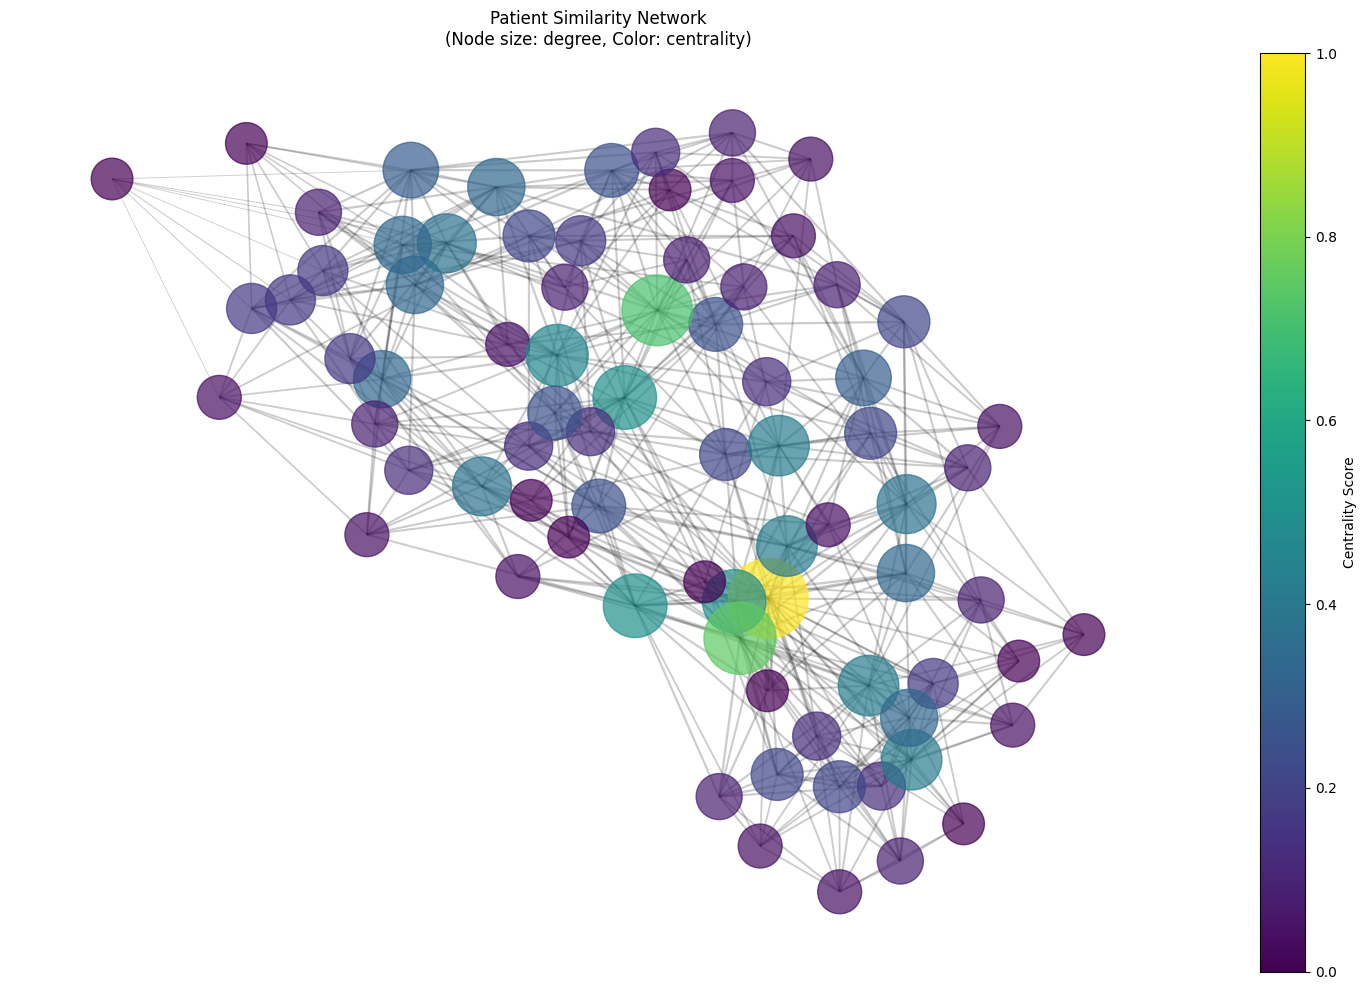

In [8]:
# Main execution
if __name__ == "__main__":
    # 1. Setup and load data
    DATA_PATH = setup_data_path()
    DATA_FILE = 'demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv'
    df = pd.read_csv(os.path.join(DATA_PATH, DATA_FILE))
    print(f"Loaded data shape: {df.shape}")

    # 2. Preprocess data
    scaled_data, feature_cols = preprocess_data(df)
    print(f"\nFeatures used: {len(feature_cols)}")

    # 3. Create network
    threshold = 0.3  # Lower threshold for more connections
    k_nearest = 8    # Connect to k nearest neighbors
    G, similarity_matrix = create_similarity_network(scaled_data, threshold=threshold, k_nearest=k_nearest)

    # 4. Analyze network
    degree_centrality, betweenness_centrality, communities = analyze_network(G)

    # 5. Visualize network
    visualize_network(G, degree_centrality)


Similarity statistics:
Min similarity: 0.002
Max similarity: 0.841
Mean similarity: 0.414
Median similarity: 0.426


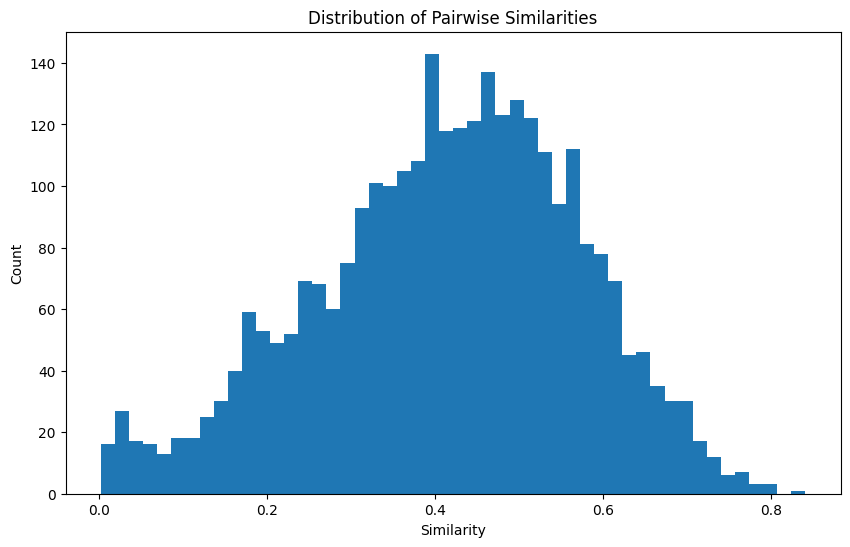

In [9]:
# Analyze similarity distribution
distances = pdist(scaled_data, metric='euclidean')
similarities = np.exp(-distances ** 2 / np.mean(distances ** 2))
print("\nSimilarity statistics:")
print(f"Min similarity: {similarities.min():.3f}")
print(f"Max similarity: {similarities.max():.3f}")
print(f"Mean similarity: {similarities.mean():.3f}")
print(f"Median similarity: {np.median(similarities):.3f}")

# Plot similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=50)
plt.title('Distribution of Pairwise Similarities')
plt.xlabel('Similarity')
plt.ylabel('Count')
plt.show()